## Benchmark 6: linear models with structured bootstrap resampling
Now that we have a resampling strategy that gives us at least some confidence that our internal benchmarking scores could be reflective of what will happened when we submit to the public leaderboard, let's start working on the model. The first thing I want to try is another shot at the OLS model and maybe some other linear regression approaches. Firstly, to see if we can make any clever improvements. But, mostly to generalize the functions written to resample, forecast and score the naive model.
1. [Abbreviations & definitions](#abbrevations_definitions)
2. [Load & inspect](#load_inspect)
3. [Helper functions](#helper_functions)

<a name="abbreviations_definitions"></a>
### 1. Abbreviations & definitions
+ MBD: microbusiness density
+ MBC: microbusiness count
+ OLS: ordinary least squares
+ Model order: number of past timepoints used as input data for model training
+ Origin (forecast origin): last known point in the input data
+ Horizon (forecast horizon): number of future data points predicted by the model
+ SMAPE: Symmetric mean absolute percentage error

<a name="load_inspect"></a>
### 2. Load & inspect

In [35]:
# Add parent directory to path to allow import of config.py
import sys
sys.path.append('..')
import config as conf
import functions.data_manipulation_functions as data_funcs

import time
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Ridge
# from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import RANSACRegressor

print(f'Python: {sys.version}')
print()
print(f'Numpy {np.__version__}')
print(f'Pandas {pd.__version__}')

Python: 3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]

Numpy 1.23.5
Pandas 1.4.3


In [36]:
# Load parsed data
block_size = 17

output_file = f'{conf.DATA_PATH}/parsed_data/structured_bootstrap_blocksize{block_size}.npy'
timepoints = np.load(output_file)

print(f'Timepoints shape: {timepoints.shape}')
print()
print('Column types:')

for column in timepoints[0,0,0,0:]:
    print(f'\t{type(column)}')

print()
print(f'Example block:\n{timepoints[0,0,0:,]}')

Timepoints shape: (20, 3135, 17, 6)

Column types:
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>

Example block:
[[ 1.0010000e+03  1.5672960e+18  2.8848701e+00  1.1980000e+03
   1.0000000e+00 -1.2281170e-01]
 [ 1.0010000e+03  1.5698880e+18  3.0558431e+00  1.2690000e+03
   2.0000000e+00  1.7097300e-01]
 [ 1.0010000e+03  1.5725664e+18  2.9932332e+00  1.2430000e+03
   3.0000000e+00 -6.2609900e-02]
 [ 1.0010000e+03  1.5751584e+18  2.9932332e+00  1.2430000e+03
   4.0000000e+00  0.0000000e+00]
 [ 1.0010000e+03  1.5778368e+18  2.9690900e+00  1.2420000e+03
   5.0000000e+00 -2.4143200e-02]
 [ 1.0010000e+03  1.5805152e+18  2.9093256e+00  1.2170000e+03
   6.0000000e+00 -5.9764400e-02]
 [ 1.0010000e+03  1.5830208e+18  2.9332314e+00  1.2270000e+03
   7.0000000e+00  2.3905800e-02]
 [ 1.0010000e+03  1.5856992e+18  3.0001674e+00  1.2550000e+03
   8.0000000e+00  6.6936000e-02]
 [ 1.0010000e+03  1.588

<a name="helper_functions"></a>
### 3. Helper functions

In [37]:
def two_point_smape(actual, forecast):
    '''Takes two datapoints and returns the SMAPE value for the pair'''

    # If SMAPE denominator is zero set SMAPE to zero
    if actual == 0 and forecast == 0:
        return 0

    # Calculate smape for forecast
    smape = abs(forecast - actual) / ((abs(actual) + abs(forecast)) / 2)
    
    return smape

In [38]:
def sample_parsed_data(timepoints, sample_size):
    '''Generates a random sample of sample_size from a random timepoint'''

    # Initialize random seed to make sure that output is differently random each call
    np.random.seed()

    # Pick random timepoint
    random_timepoint_index = np.random.choice(timepoints.shape[0], 1)
    timepoint = timepoints[random_timepoint_index][0]

    if sample_size == 'all':
        return timepoint

    # Pick n unique random county indexes to include in the sample
    random_county_indices = np.random.choice(timepoint.shape[0], sample_size, replace=False)

    # Use random indices to extract sample from timepoint
    sample = timepoint[random_county_indices]

    return sample

In [39]:
def make_forecasts(block, model_types, model_order, time_fit = False):
    '''Uses specified model type and model order to forecast
    within block, one timepoint into the future. Also returns
    naive, 'carry-forward' prediction for the same datapoint 
    for comparison'''

    # Holder for SMAPE values
    block_predictions = {
        'model_type': [],
        'model_order': [],
        'MBD_predictions': [],
        'detrended_MBD_predictions': [],
        'MBD_inputs': [],
        'detrended_MBD_inputs': []
    }

    # Get prediction for naive control. Note: these are indexes
    # so model_order gets the model_order th element (zero anchored)
    block_predictions['model_type'].append('control')
    block_predictions['model_order'].append(model_order)
    block_predictions['MBD_predictions'].append(block[(model_order - 1), 2])
    block_predictions['detrended_MBD_predictions'].append(block[(model_order - 1), 5] + block[model_order, 2])

    # X input is model_order sequential integers
    x_input = list(range(model_order))

    # Y input is MBD values starting from the left
    # edge of the block, up to the model order. Note: this
    # is a slice so, the right edge is exclusive 
    y_input = list(block[:model_order, 2])
    detrended_y_input = list(block[:model_order, 5])

    block_predictions['MBD_inputs'].append(y_input)
    block_predictions['detrended_MBD_inputs'].append(detrended_y_input)

    # Forecast X input is sequential integers starting
    # after the end of the X input. Note: we are only interested
    # in the first prediction here, but some statsmodels estimators
    # expect the same dim during forecast as they were fitted 
    forecast_x = list(range(model_order, (model_order * 2)))

    for model_type in model_types:

        start_time = time.time()

        if model_type == 'OLS':

            # Add model type to results
            block_predictions['model_type'].append(model_type)

            # Add model order to results
            block_predictions['model_order'].append(model_order)

            block_predictions['MBD_inputs'].append(y_input)
            block_predictions['detrended_MBD_inputs'].append(detrended_y_input)

            # Fit and predict raw data
            model = sm.OLS(y_input, sm.add_constant(x_input)).fit()
            prediction = model.predict(sm.add_constant(forecast_x))

            # Collect forecast
            block_predictions['MBD_predictions'].append(prediction[0])

            # Fit and predict detrended data
            model = sm.OLS(detrended_y_input, sm.add_constant(x_input)).fit()
            prediction = model.predict(sm.add_constant(forecast_x))

            # Collect forecast
            block_predictions['detrended_MBD_predictions'].append(prediction[0] + block[model_order, 2])

        if model_type == 'TS':

            # Add model type to results
            block_predictions['model_type'].append(model_type)

            # Add model order to results
            block_predictions['model_order'].append(model_order)

            block_predictions['MBD_inputs'].append(y_input)
            block_predictions['detrended_MBD_inputs'].append(detrended_y_input)

            # Fit Theil-Sen to raw data
            ts = stats.theilslopes(y_input, x_input)

            # Calculate forecast from Theil-Sen slope and intercept, add to results
            block_predictions['MBD_predictions'].append(ts[1] + ts[0] * forecast_x[0])

            # Fit Theil-Sen to detrended data
            ts = stats.theilslopes(detrended_y_input, x_input)

            # Calculate forecast from Theil-Sen slope and intercept, add to results
            block_predictions['detrended_MBD_predictions'].append((ts[1] + ts[0] * forecast_x[0]) + block[model_order, 2])

        if model_type == 'Seigel':

            # Add model type to results
            block_predictions['model_type'].append(model_type)

            # Add model order to results
            block_predictions['model_order'].append(model_order)

            block_predictions['MBD_inputs'].append(y_input)
            block_predictions['detrended_MBD_inputs'].append(detrended_y_input)

            # Fit Seigel to raw data
            ss = stats.siegelslopes(y_input, x_input)

            # Calculate forecast from Seigel slope and intercept, add to results
            block_predictions['MBD_predictions'].append(ss[1] + ss[0] * forecast_x[0])

            # Fit Theil-Sen to detrended data
            ss = stats.siegelslopes(detrended_y_input, x_input)

            # Calculate forecast from Seigel slope and intercept, add to results
            block_predictions['detrended_MBD_predictions'].append((ss[1] + ss[0] * forecast_x[0]) + block[model_order, 2])

        if model_type == 'Ridge':

            # Add model type to results
            block_predictions['model_type'].append(model_type)

            # Add model order to results
            block_predictions['model_order'].append(model_order)

            block_predictions['MBD_inputs'].append(y_input)
            block_predictions['detrended_MBD_inputs'].append(detrended_y_input)

            # Fit ridge to raw data
            ridge = Ridge()
            ridge.fit(np.array(x_input).reshape(-1, 1), np.array(y_input).reshape(-1, 1))

            # Get prediction, add to results
            block_predictions['MBD_predictions'].append(ridge.predict(np.array(forecast_x).reshape(-1, 1))[0][0])

            # Fit ridge to detrended data
            ridge = Ridge()
            ridge.fit(np.array(x_input).reshape(-1, 1), np.array(detrended_y_input).reshape(-1, 1))

            # Get prediction, add to results
            block_predictions['detrended_MBD_predictions'].append(ridge.predict(np.array(forecast_x).reshape(-1, 1))[0][0] + block[model_order, 2])

        dT = time.time() - start_time

        if time_fit == True:
            print(f'{model_type}, order {model_order}: {dT} sec.')  

    return block_predictions

In [40]:
def smape_score_models(sample, model_types, model_order, time_fit = False):
    '''Takes a sample of blocks, makes forecast for each 
    and collects resulting SMAPE values'''

    # Holder for SMAPE values
    block_data = {
        'model_type': [],
        'model_order': [],
        'SMAPE_values': [],
        'detrended_SMAPE_values': [],
        'MBD_predictions': [],
        'detrended_MBD_predictions': [],
        'MBD_inputs': [],
        'detrended_MBD_inputs': [],
        'MBD_actual': []
    }

    for block_num in range(sample.shape[0]):

        # Get the forecasted value(s)
        block_predictions = make_forecasts(sample[block_num], model_types, model_order, time_fit)

        # Collect predictions, input data and model info.
        for key, value in block_predictions.items():
            block_data[key].extend(value)

        # Get the true value and add to data
        actual_value = sample[block_num, model_order, 2]

        # Get and collect SMAPE value for models
        for value in block_predictions['MBD_predictions']:

            smape_value = two_point_smape(actual_value, value)
            block_data['SMAPE_values'].append(smape_value)
            block_data['MBD_actual'].append(actual_value)

        # Get and collect SMAPE value for models
        for value in block_predictions['detrended_MBD_predictions']:

            smape_value = two_point_smape(actual_value, value)
            block_data['detrended_SMAPE_values'].append(smape_value)

    return block_data

In [41]:
def bootstrap_smape_scores(timepoints, sample_num, sample_size, model_order, model_types, time_fit = False):

    # Holder for sample results
    sample_data = {
        'sample': [],
        'model_type': [],
        'model_order': [],
        'SMAPE_values': [],
        'detrended_SMAPE_values': [],
        'MBD_predictions': [],
        'detrended_MBD_predictions': [],
        'MBD_inputs': [],
        'detrended_MBD_inputs': [],
        'MBD_actual': []
    }

    # Generate sample of random blocks from random timepoint
    sample = sample_parsed_data(timepoints, sample_size)

    # Do forecast and aggregate score across each block in sample
    result = smape_score_models(sample, model_types, model_order, time_fit)

    # Add sample results
    for key, value in result.items():
        sample_data[key].extend(value)
T = time.time() - start_time
    # Fill sample number in 
    sample_data['sample'].extend([sample_num] * len(result['model_type']))

    return sample_data

In [42]:
def parallel_bootstrapped_smape(
    timepoints, 
    sample_num, 
    sample_size, 
    model_orders, 
    model_types,
    time_fit = False
):
    
    # Holder for sample results
    data = {
        'sample': [],
        'model_type': [],
        'model_order': [],
        'SMAPE_values': [],
        'detrended_SMAPE_values': [],
        'MBD_predictions': [],
        'detrended_MBD_predictions': [],
        'MBD_inputs': [],
        'detrended_MBD_inputs': [],
        'MBD_actual': []
    }

    # Loop on model orders
    for model_order in model_orders:
        result = bootstrap_smape_scores(            
            timepoints, 
            sample_num, 
            sample_size, 
            model_order, 
            model_types,
            time_fit
        )

        # Add results for this order
        for key, value in result.items():
            data[key].extend(value)

    return data

In [43]:
# Set run parameters
num_samples = 240
sample_size = 300
model_orders = [4,6,8,10,16]
model_types = ['OLS', 'TS', 'Seigel', 'Ridge']
time_fit = False

# Fire up the pool
pool, result_objects = data_funcs.start_multiprocessing_pool()

# Loop on samples, assigning each to a different worker
for sample_num in range(sample_size):

    result = pool.apply_async(parallel_bootstrapped_smape,
        args = (
            timepoints, 
            sample_num, 
            sample_size, 
            model_orders, 
            model_types,
            time_fit
        )
    )

    # Add result to collection
    result_objects.append(result)

# Get and parse result objects, clean up pool
data = data_funcs.cleanup_bootstrapping_multiprocessing_pool(pool, result_objects)

Starting processes for 18 CPUs (available - 2)



In [44]:
# Inspect results - each row is an individual datapoint from a sample
data_df = pd.DataFrame(data)
data_df.head(5)

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
0,0,control,4,0.000000,0.000000,1.619148,1.619148,"[1.4783527, 1.5839493, 1.6191481, 1.6191481]","[0.0, 0.10559659999999993, 0.03519880000000008...",1.619148
1,0,OLS,4,0.042553,0.010811,1.689546,1.636748,"[1.4783527, 1.5839493, 1.6191481, 1.6191481]","[0.0, 0.10559659999999993, 0.03519880000000008...",1.619148
2,0,TS,4,0.051191,0.016438,1.704212,1.592749,"[1.4783527, 1.5839493, 1.6191481, 1.6191481]","[0.0, 0.10559659999999993, 0.03519880000000008...",1.619148
3,0,Seigel,4,0.032085,0.021978,1.671946,1.583949,"[1.4783527, 1.5839493, 1.6191481, 1.6191481]","[0.0, 0.10559659999999993, 0.03519880000000008...",1.619148
4,0,Ridge,4,0.031208,0.012601,1.670480,1.639681,"[1.4783527, 1.5839493, 1.6191481, 1.6191481]","[0.0, 0.10559659999999993, 0.03519880000000008...",1.619148
5,0,control,4,0.002260,0.018265,1.501644,1.471137,"[1.5084234, 1.5152029, 1.5287617, 1.501644]","[0.0881326, 0.006779499999999938, 0.0135587999...",1.498254
6,0,OLS,4,0.009009,0.043931,1.511813,1.433850,"[1.5084234, 1.5152029, 1.5287617, 1.501644]","[0.0881326, 0.006779499999999938, 0.0135587999...",1.498254


In [101]:
# Calculate the final SMAPE score for each sample in each condition
sample_smape_scores_df = data_df.groupby(['sample', 'model_type', 'model_order'])[['SMAPE_values', 'detrended_SMAPE_values']].mean().mul(100)

# Rename columns to reflect the change from SMAPE values for a single prediction to
# SMAPE scores within a sample
sample_smape_scores_df.rename(inplace=True, columns={'SMAPE_values': 'SMAPE_score', 'detrended_SMAPE_values': 'detrended_SMAPE_score'})

# Clean up index and inspect. Now each sample in all of the conditions is represented by a single row
# with two SMAPE scores calculated from all of the datapoints in that condition and sample. One from
# the fit and forecast on the raw data and the other from the fit and forecast on the difference
# detrended data
sample_smape_scores_df.reset_index(inplace=True, drop=False)
sample_smape_scores_df.head()

,sample,model_type,model_order,SMAPE_score,detrended_SMAPE_score
0,0,OLS,4,2.747421,2.436671
1,0,OLS,6,2.152979,2.923387
2,0,OLS,8,3.412416,2.787528
3,0,OLS,10,3.282610,1.794875
4,0,OLS,16,2.855967,1.405953


OK, let's take a look! Going to use a boxplot to look at the distribution of sample SMAPE scores across the different models and model orders. We also have fits to the raw and detrended data to look at. Keep in mind that the detrended fit was used to generate a raw MBD value for scoring purposes, so the underlying scale of the raw and detrended data panels are the same.

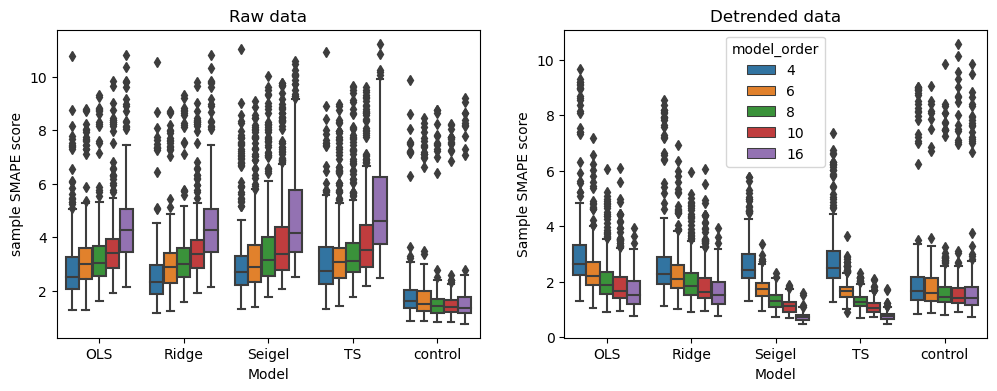

In [102]:
fig, ax = plt.subplots(1, 2,figsize=(12,4))

sns.boxplot(
    data=sample_smape_scores_df, 
    x='model_type',
    y='SMAPE_score',
    hue='model_order',
    ax=ax[0]
)

ax[0].set(
    xlabel='Model', 
    ylabel='sample SMAPE score', 
    title='Raw data'
)

ax[0].get_legend().remove()

sns.boxplot(
    data=sample_smape_scores_df, 
    x='model_type',
    y='detrended_SMAPE_score',
    hue='model_order',
    ax=ax[1]
)

ax[1].set(
    xlabel='Model', 
    ylabel='Sample SMAPE score', 
    title='Detrended data'
)

plt.show()

Nice! So it looks like we might actually be beating our naive, 'carry-forward' control. Couple of observations here:
1. Fitting to the detrended data works best for the linear regression models over all.
2. All of the distributions have long-ish tails to high values.
3. The linear regression models with detrended data all benefit from a larger model order.
4. Seigel and Theil-Sen regression with detrended data look like the winners - with large model orders, both are getting the lowest mean sample SMAPE values and have the tightest spread of sample SMAPE values.
5. The control looks like it does a little bit better on the raw data than the detrended data.
6. The control seems like it may actually benefit slightly from a larger model order.

That last point seems a bit suspect, given the fact that the control is taking the last value from the input series as the forecast. It may be that those distributions are not really different and simply reflect between sample-of-samples variability. Let's move on for now, but keep it in mind.

Next take away is that I think we should be comparing the control with the raw data to the models with the detrended data. Doing so gives the control it's best shot and matches the setup used to produce our public leaderboard benchmark score of ~1.09.

Last thing to say for now is, let's focus on the detrended data and Siegel/Theil-Sen regression, with large model orders. Keep in mind that although both look to be doing better than the control over all - it's not by a wide margin and the spread of model and control sample SMAPE distributions are such that with some samples our regression models may loose to the control and vice versa.

Now, let's compare another way by plotting individual SMAPE values for all the datapoints for control vs regression.


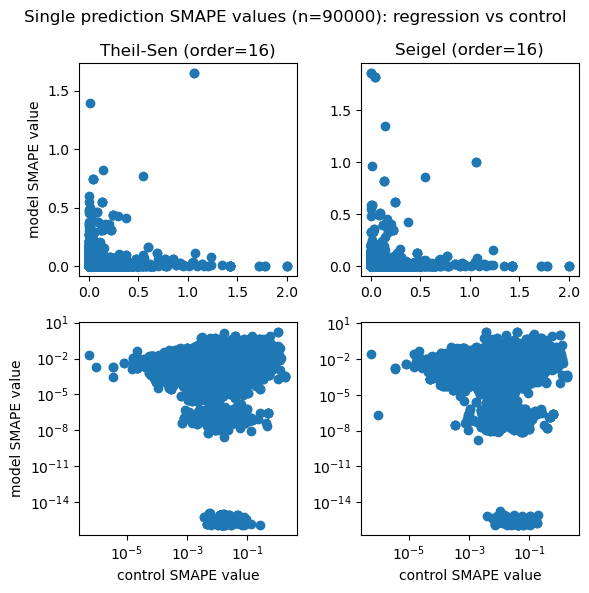

In [103]:
fig, ax = plt.subplots(2, 2, figsize=(6,6))

ax[0,0].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 10)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == 10)]['detrended_SMAPE_values']
)

#ax[0,0].set_xlabel('control SMAPE value')
ax[0,0].set_ylabel('model SMAPE value')
ax[0,0].set_title('Theil-Sen (order=16)')

ax[0,1].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 10)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 10)]['detrended_SMAPE_values']
)

#ax[0,1].set_xlabel('control SMAPE value')
#ax[0,1].set_ylabel('model SMAPE value')
ax[0,1].set_title('Seigel (order=16)')

ax[1,0].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 10)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == 10)]['detrended_SMAPE_values']
)

ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')

ax[1,0].set_xlabel('control SMAPE value')
ax[1,0].set_ylabel('model SMAPE value')
#ax[1,0].set_title('Theil-Sen (order=16)')

ax[1,1].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 10)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 10)]['detrended_SMAPE_values']
)

ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')

ax[1,1].set_xlabel('control SMAPE value')
#ax[1,1].set_ylabel('model SMAPE value')
#ax[1,1].set_title('Seigel (order=16)')

n = len(data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == 10)]['detrended_SMAPE_values'])
plt.suptitle(f'Single prediction SMAPE values (n={n}): regression vs control')
plt.tight_layout()

This plot is pretty cool - it shows the SMAPE score received by the control vs the regression models for each individual prediction across all of the samples. We can see that for both regression models, there are cases where the control gets a low score and the model gets a high score (upper left) and vice versa (lower right). In fact, it is interesting to note th 'L' shape of the point cloud. The shape indicates that datapoints which are predicted badly by one approach are predicted well by the other approach and this is especially true for the worst scored examples for each. This is a fascinating observation because it suggests an interesting idea - what if we used both the 'carry-forward' and a regression model as complementary approaches? Looking at the log-log plots, it appears to be a small fraction of the data, but all of the worst scoring points seem to follow the score complementarity rule described above. Neat.

Let's at least take a closer look at our winners.

In [104]:
# Aggregate scores again, this time averaging all of the samples in each condition so we have one datapoint for each model and order
mean_sample_smape_score_df = sample_smape_scores_df.groupby(['model_type', 'model_order'])[['SMAPE_score', 'detrended_SMAPE_score']].mean()

# Rename columns to reflect new value
mean_sample_smape_score_df.rename(inplace=True, columns={'SMAPE_score': 'mean_SMAPE_score', 'detrended_SMAPE_score': 'mean_detrended_SMAPE_score'})

# Clean up and inspect
mean_sample_smape_score_df.reset_index(inplace=True, drop=False)
mean_sample_smape_score_df.head()

,model_type,model_order,mean_SMAPE_score,mean_detrended_SMAPE_score
0,OLS,4,2.903090,3.115341
1,OLS,6,3.231952,2.412292
2,OLS,8,3.369816,2.134893
3,OLS,10,3.671434,1.923824
4,OLS,16,4.509635,1.629281


In [117]:
# Get top 10 models by mean detrended SMAPE score
detrended_top_10 = mean_sample_smape_score_df.sort_values(by=['mean_detrended_SMAPE_score']).head(10)

# Get winner type and order
winning_model_type = detrended_top_10['model_type'].to_list()[0]
winning_model_order = detrended_top_10['model_order'].to_list()[0]

# Get raw data for winner
winner = data_df[(data_df['model_type'] == winning_model_type) & (data_df['model_order'] == winning_model_order)]

# Get raw data for sample matched control
control = data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == winning_model_order)]

# Inspect
control.head(3)

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
6000,0,control,16,0.001195,0.002387,2.332589,2.340960,"[2.3647707, 2.2784245, 2.320205, 2.320205, 2.3...","[-0.04540440000000023, -0.08634619999999993, 0...",2.335379
6005,0,control,16,0.001986,0.017699,3.448276,3.516830,"[3.4926343, 3.5479631, 3.5133827, 3.4442215, 3...","[-0.05617929999999971, 0.055328799999999845, -...",3.455131
6010,0,control,16,0.002714,0.002706,7.116612,7.155289,"[7.2389793, 7.15943, 7.179317, 7.15943, 7.1461...","[-0.31160120000000013, -0.07954929999999916, 0...",7.135951


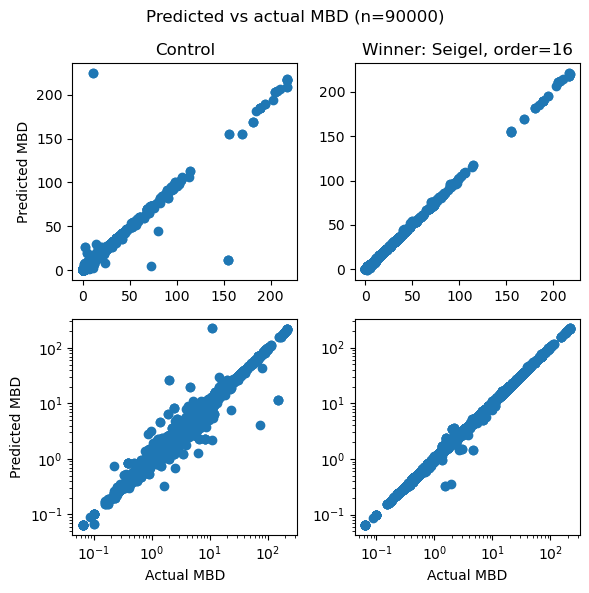

In [118]:
# Plot true vs predicted values
fig, ax = plt.subplots(2, 2, figsize=(6,6))

ax[0,0].scatter(
    control['MBD_actual'],
    control['MBD_predictions']
)

#ax[0,0].set_xlabel('Actual MBD')
ax[0,0].set_ylabel('Predicted MBD')
ax[0,0].set_title('Control')


ax[0,1].scatter(
    winner['MBD_actual'],
    winner['detrended_MBD_predictions']
)

#ax[0,1].set_xlabel('Actual MBD')
#ax[1].set_ylabel('Predicted MBD')
ax[0,1].set_title(f'Winner: {winning_model_type}, order={winning_model_order}')

ax[1,0].scatter(
    control['MBD_actual'],
    control['MBD_predictions']
)

ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')

ax[1,0].set_xlabel('Actual MBD')
ax[1,0].set_ylabel('Predicted MBD')
#ax[1,0].set_title('Control')

ax[1,1].scatter(
    winner['MBD_actual'],
    winner['detrended_MBD_predictions']
)

ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')

ax[1,1].set_xlabel('Actual MBD')
#ax[1].set_ylabel('Predicted MBD')
#ax[1,1].set_title(f'Winner: {winning_model_type}, order={winning_model_order}')

n = len(winner['MBD_actual'])
plt.suptitle(f'Predicted vs actual MBD (n={n})')
#plt.setp(ax, xlim=(-10,250), ylim=(-10,250))
plt.tight_layout()

This looks VERY good, The winning model with the detrended data is straight as an arrow, even on a log-log plot, with very few exceptions. But, remember we are sampling - so we might have bad luck on the leaderboard.

As one more way to look at the control and winning score distributions, let's work up some basic summary stats with pandas describe

In [121]:
control_sample_means

,sample,model_type,model_order,SMAPE_score,detrended_SMAPE_score
24,0,control,16,0.801114,1.266760
49,1,control,16,1.186543,1.262311
74,2,control,16,1.176368,2.140270
99,3,control,16,1.201484,1.054880
124,4,control,16,2.397105,1.919151
...,...,...,...,...,...
7399,295,control,16,1.246242,0.928628
7424,296,control,16,1.622966,1.175458
7449,297,control,16,1.169852,2.109474
7474,298,control,16,0.878462,1.577765


In [122]:
control_sample_smape_scores = sample_smape_scores_df[(sample_smape_scores_df['model_type'] == 'control') & (sample_smape_scores_df['model_order'] == winning_model_order)]
control_sample_smape_scores['SMAPE_score'].describe()

count    300.000000
mean       1.713548
std        1.345438
min        0.763574
25%        1.171411
50%        1.365482
75%        1.775556
max        9.198850
Name: SMAPE_score, dtype: float64

In [124]:
winner_sample_smape_scores = sample_smape_scores_df[(sample_smape_scores_df['model_type'] == winning_model_type) & (sample_smape_scores_df['model_order'] == winning_model_order)]
winner_sample_smape_scores['detrended_SMAPE_score'].describe()

count    300.000000
mean       0.738013
std        0.142196
min        0.482889
25%        0.633561
50%        0.712880
75%        0.813874
max        1.598812
Name: detrended_SMAPE_score, dtype: float64

So, for context, the naive model gets ~1.1 on the public leaderboard. From our earlier bootstrapping experiments (see notebook #10), we determined that the probability of drawing a sample from the training dataset that scores as well or better with the naive control was about 1 in 4. The mean of the resampling distribution was ~1.9. In this experiment, we are seeing a mean of 1.7 and a standard deviation of 1.3 for the control. Looking at the percentiles, we see scores of ~1.2 at the 25<sup>th</sup> and 1.8 at the 75<sup>th</sup>. So again, our observed control leaderboard score is a pretty good showing for the naive model but, not crazy.

Our winning model has a mean of 0.73 and a 25<sup>th</sup> to 75<sup>th</sup> percentile range of 0.63 to 0.81. If we hit the 25<sup>th</sup> percentile again, we are in great shape - but in reality there is no guarantee of this, we could very likely still see a score worse that the control.

We could probably tighten up the ranges a bit with more/larger samples. But at some point it doesn't really matter in terms of the leaderboard score. Yes, it may be true that over a large number of trials Theil-Sen beats the naive control. But it may not on the specific timepoint used for leaderboard scoring.

Last thing I want to do is run a quick test for difference of means and see if we can assign a significance level to it.

In [134]:
t_test = stats.ttest_ind(winner_sample_smape_scores['detrended_SMAPE_score'], control_sample_smape_scores['SMAPE_score'])
print(f't-test p-value (H0: control mean = regression mean): {t_test[1]:.2E}')

t-test p-value (H0: control mean = regression mean): 5.71E-32


In [132]:

import statsmodels.stats.api as sms

cm = sms.CompareMeans(sms.DescrStatsW(winner_sample_smape_scores['detrended_SMAPE_score']), sms.DescrStatsW(control_sample_smape_scores['SMAPE_score']))
ci = cm.tconfint_diff(usevar='unequal')
print(f'95% C.I. around difference in means: {ci[0]:.2f}, {ci[1]:.3f}')

95% C.I. around differene in means: -1.13, -0.822


Pretty much what I thought - the results do suggest that the distributions actually are different, but the difference is small enough and the spread large enough that for one sample we could easily still do worse with the regression model.

To see what I mean, let's calculate the probability of drawing a score worse than the control public leaderboard result (1.094) from the regression model's resampling distribution.

In [131]:
from statistics import NormalDist

smape_mean = statistics.mean(winner_sample_smape_scores['detrended_SMAPE_score'])
smape_std = statistics.pstdev(winner_sample_smape_scores['detrended_SMAPE_score'])

print(f'Mean: {smape_mean:.3f}')
print(f'Standard deviation: {smape_std:.3f}')
print()

leaderboard_score_probability = NormalDist(mu=smape_mean, sigma=smape_std).cdf(1.0936)
print(f'Probability of SMAPE <= 1.0936: {leaderboard_score_probability:.3f}')
print(f'Probability of SMAPE > 1.0936: {1 - leaderboard_score_probability:.3f}')

Mean: 0.738
Standard deviation: 0.142

Probability of SMAPE <= 1.0936: 0.994
Probability of SMAPE > 1.0936: 0.006


OK, never mind - it looks pretty likely that we will beat it!

I'v got two ideas here to give this thing a little boost:
1) Choose model order dynamically.
2) If the linear model is bad for a given data point, use the naive control value instead.

To do that we need some way to quantify how well the model is doing before we know the answer. Before we dig into it, let's just look and see if we have points where picking another model order would help and/or points where using the naive model would be better.

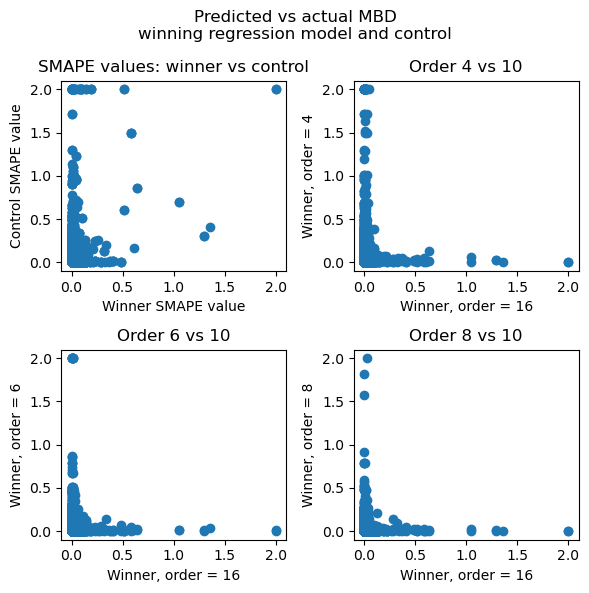

In [57]:
# Get raw data for winner
winner_order4 = data_df[(data_df['model_type'] == winning_model_type) & (data_df['model_order'] == 4.0)]
winner_order6 = data_df[(data_df['model_type'] == winning_model_type) & (data_df['model_order'] == 6.0)]
winner_order8 = data_df[(data_df['model_type'] == winning_model_type) & (data_df['model_order'] == 8.0)]

# Plot true vs predicted values
fig, ax = plt.subplots(2, 2, figsize=(6,6))

ax[0,0].scatter(
    winner['detrended_SMAPE_values'],
    control['detrended_SMAPE_values']
)
ax[0,0].set_xlabel('Winner SMAPE value')
ax[0,0].set_ylabel('Control SMAPE value')
ax[0,0].title.set_text('SMAPE values: winner vs control')

ax[0,1].scatter(
    winner['detrended_SMAPE_values'],
    winner_order4['detrended_SMAPE_values']
)
ax[0,1].set_xlabel(f'Winner, order = {winning_model_order}')
ax[0,1].set_ylabel(f'Winner, order = 4')
ax[0,1].title.set_text('Order 4 vs 10')

ax[1,0].scatter(
    winner['detrended_SMAPE_values'],
    winner_order6['detrended_SMAPE_values']
)
ax[1,0].set_xlabel(f'Winner, order = {winning_model_order}')
ax[1,0].set_ylabel(f'Winner, order = 6')
ax[1,0].title.set_text('Order 6 vs 10')

ax[1,1].scatter(
    winner['detrended_SMAPE_values'],
    winner_order8['detrended_SMAPE_values']
)
ax[1,1].set_xlabel(f'Winner, order = {winning_model_order}')
ax[1,1].set_ylabel(f'Winner, order = 8')
ax[1,1].title.set_text('Order 8 vs 10')

plt.suptitle('Predicted vs actual MBD\nwinning regression model and control')
#plt.setp(ax, xlim=(-10,210), ylim=(-10,210))
plt.tight_layout()

Yep - in each case, either the control or other model orders we have some extreme cases where our winner does badly and using the control value or a different model order would yield a better score. Let's try it - thing to do is recover the fit statistics and see if we can pick out points that are going to give high SMAPE values from the results of the fits alone.

It looks like the Theil-Sen regressor from SciPy returns the slope, intercept and also a confidence interval around the slope. We could use the width of the confidence interval as a handle for the 'goodness of fit'. But now that i'm thinking about it, it's not immediately obvious if we want 'good' fits or 'bad' fits. I could imagine it either way: a 'good' TS fit means a good TS prediction, or a bad TS fit means there is something funky going on where naive would actually do worse. Let's try plotting the MBD data for a few good TS results and a few bad TS results and see what it looks like.

In [58]:
low_SMAPE = winner.sort_values(by='detrended_SMAPE_values')
low_SMAPE.head()

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
2046493,272,Seigel,16,0.081822,0.0,1.730294,1.594283,"[1.7827756, 1.8401538, 1.7577589, 1.7302939, 1...","[-0.0274274000000001, 0.057378200000000046, -0...",1.594283
1536548,204,Seigel,16,0.048601,0.0,1.099170,1.047017,"[1.1284046, 1.0894941, 1.0894941, 1.0116731, 1...","[0.019455200000000117, -0.03891050000000007, 0...",1.047017
914058,121,Seigel,16,0.005304,0.0,0.911649,0.916497,"[1.2597889, 1.0214504, 1.0341262, 1.0685971, 1...","[0.0, -0.2383385, 0.012675800000000015, 0.0344...",0.916497
1536568,204,Seigel,16,0.026847,0.0,0.978401,1.005025,"[1.1421319, 1.0786802, 0.95177662, 0.95177662,...","[0.06345170000000011, -0.06345170000000011, -0...",1.005025
464933,61,Seigel,16,0.003827,0.0,1.409656,1.415060,"[1.4411298, 1.4843638, 1.4771581, 1.4627467, 1...","[0.008959999999999857, 0.043233999999999995, -...",1.415060


In [59]:
high_SMAPE = winner.sort_values(by='detrended_SMAPE_values', ascending=False)
high_SMAPE.reset_index(inplace=True, drop=True)
high_SMAPE.head()

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
0,189,Seigel,16,1.664172,2.000000,0.130269,-0.723425,"[42.205891, 40.907246, 40.169075, 7.2447958, 3...","[-2.3718259999999987, -1.2986450000000005, -0....",1.421343
1,7,Seigel,16,1.664172,2.000000,0.130269,-0.723425,"[42.205891, 40.907246, 40.169075, 7.2447958, 3...","[-2.3718259999999987, -1.2986450000000005, -0....",1.421343
2,224,Seigel,16,0.222042,1.358637,1.519984,0.362753,"[12.26938, 11.821425, 11.973274, 11.684762, 11...","[0.0987019999999994, -0.4479550000000003, 0.15...",1.899633
3,231,Seigel,16,0.634177,1.292100,0.783316,0.324853,"[11.821425, 11.973274, 11.684762, 11.745502, 1...","[-0.4479550000000003, 0.15184900000000034, -0....",1.510732
4,296,Seigel,16,0.634177,1.292100,0.783316,0.324853,"[11.821425, 11.973274, 11.684762, 11.745502, 1...","[-0.4479550000000003, 0.15184900000000034, -0....",1.510732


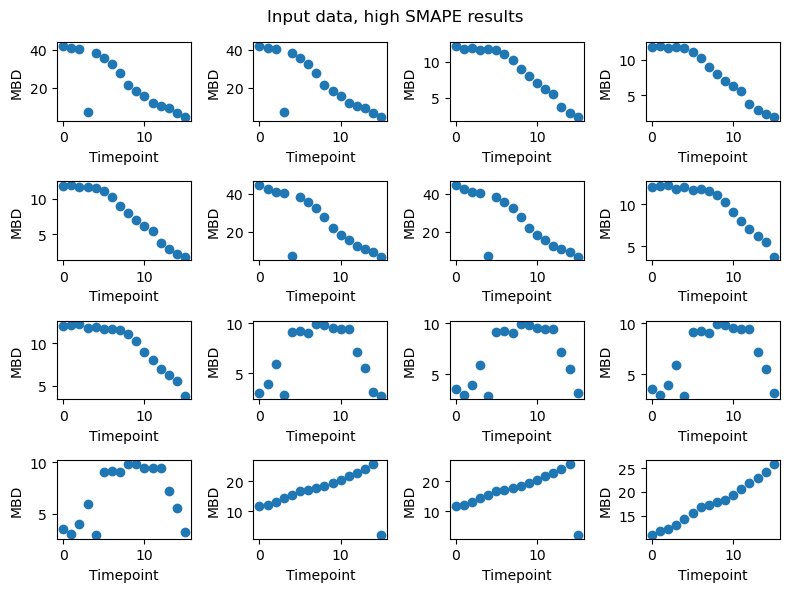

In [60]:
plot_rows = 4
plot_cols = 4
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(8,6))

for i in range(plot_rows):
    for j in range(plot_cols):

        data_point = high_SMAPE.iloc[[plot_num]]
        MBD_values = list(data_point['MBD_inputs'])[0]

        ax[i,j].scatter(
            list(range(len(MBD_values))),
            MBD_values
        )
        ax[i,j].set_xlabel(f'Timepoint')
        ax[i,j].set_ylabel(f'MBD')

        plot_num += 1

plt.suptitle('Input data, high SMAPE results')
#plt.setp(ax, xlim=(-10,210), ylim=(-10,210))
plt.tight_layout()

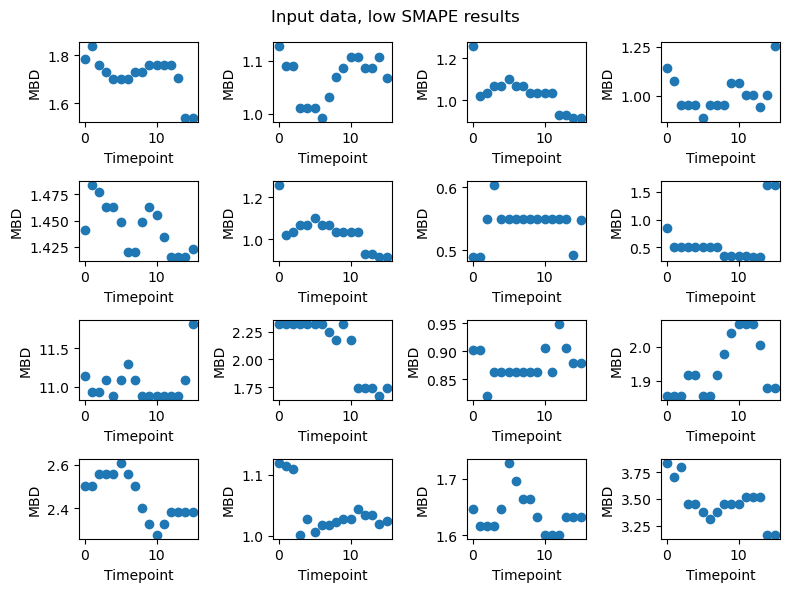

In [61]:
plot_rows = 4
plot_cols = 4
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(8,6))

for i in range(plot_rows):
    for j in range(plot_cols):

        data_point = low_SMAPE.iloc[[plot_num]]
        MBD_values = list(data_point['MBD_inputs'])[0]

        ax[i,j].scatter(
            list(range(len(MBD_values))),
            MBD_values
        )
        ax[i,j].set_xlabel(f'Timepoint')
        ax[i,j].set_ylabel(f'MBD')

        plot_num += 1

plt.suptitle('Input data, low SMAPE results')
#plt.setp(ax, xlim=(-10,210), ylim=(-10,210))
plt.tight_layout()

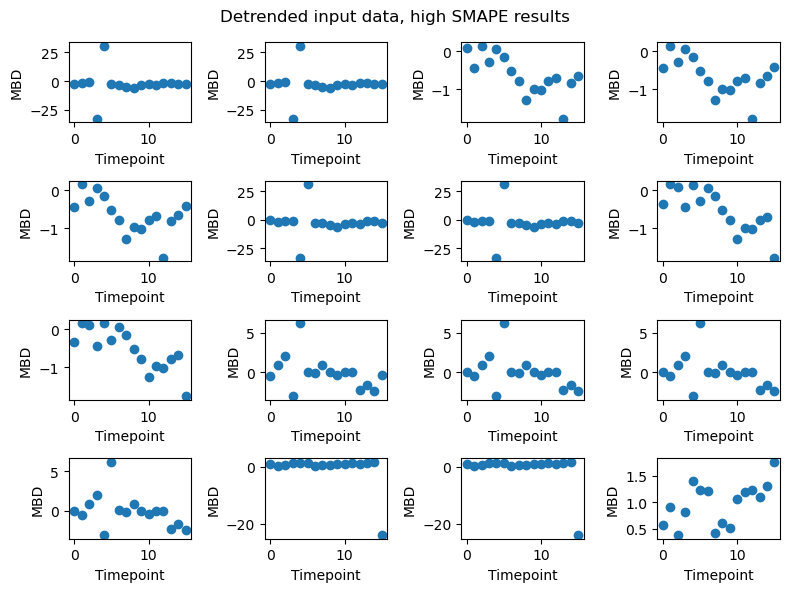

In [62]:
plot_rows = 4
plot_cols = 4
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(8,6))

for i in range(plot_rows):
    for j in range(plot_cols):

        data_point = high_SMAPE.iloc[[plot_num]]
        MBD_values = list(data_point['detrended_MBD_inputs'])[0]

        ax[i,j].scatter(
            list(range(len(MBD_values))),
            MBD_values
        )
        ax[i,j].set_xlabel(f'Timepoint')
        ax[i,j].set_ylabel(f'MBD')

        plot_num += 1

plt.suptitle('Detrended input data, high SMAPE results')
#plt.setp(ax, xlim=(-10,210), ylim=(-10,210))
plt.tight_layout()

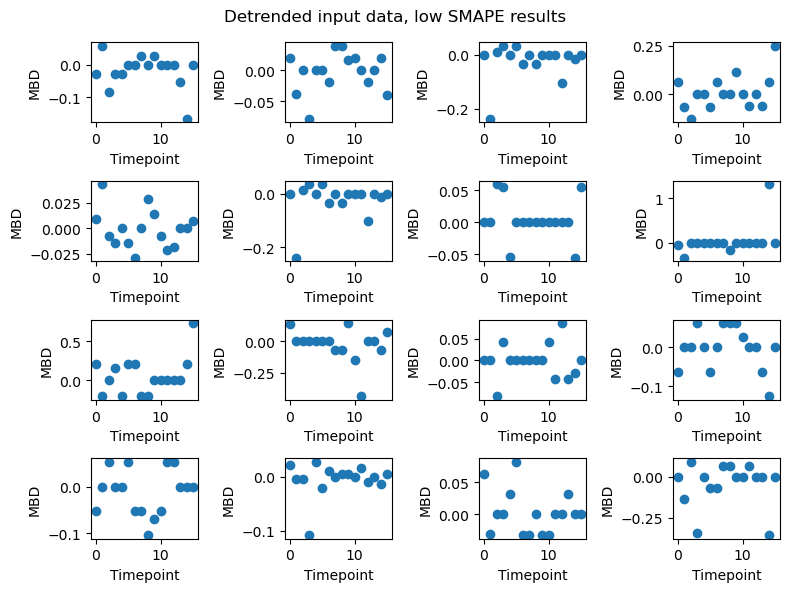

In [63]:
plot_rows = 4
plot_cols = 4
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(8,6))

for i in range(plot_rows):
    for j in range(plot_cols):

        data_point = low_SMAPE.iloc[[plot_num]]
        MBD_values = list(data_point['detrended_MBD_inputs'])[0]

        ax[i,j].scatter(
            list(range(len(MBD_values))),
            MBD_values
        )
        ax[i,j].set_xlabel(f'Timepoint')
        ax[i,j].set_ylabel(f'MBD')

        plot_num += 1

plt.suptitle('Detrended input data, low SMAPE results')
#plt.setp(ax, xlim=(-10,210), ylim=(-10,210))
plt.tight_layout()

OK, looking at the plots, I think it's pretty clear what is going on. If the MBD is changing too much, or has discontinuities or different change regimes in the time window, Theil-Sen does not do so well. In these cases it might be better to use a different model order or just pick the naive control value. So, I think either mean fit error or even the data range could be useful in spotting this. Let's make two more plots:
1. Data range vs SMAPE value
2. Fit residuals vs SMAPE value

And see if we can use either to make a reasonable threshold to detect 'bad' TS fits.

In [64]:
import statistics

data_ranges = []
SMAPE_values = []
theil_slopes = []
total_fit_residuals = []
mean_fit_residuals = []
total_residuals_as_fraction_of_range = []
mean_residuals_as_fraction_of_range = []
slope_range = []
input_variance = []
input_deviation = []
input_absolute_sum = []

for i in range(len(winner)):

    # Get data for this row
    data_point = winner.iloc[[i]]
    input_data = list(data_point['detrended_MBD_inputs'])[0]
    SMAPE_value = list(data_point['detrended_SMAPE_values'])[0]
    data_range = max(input_data) - min(input_data)

    if data_range != 0:

        # Collect absolute input sum
        absolute_sum = 0
        
        for data in input_data:
            absolute_sum += abs(data)

        input_absolute_sum.append(absolute_sum)

        # Collect input variance
        input_variance.append(statistics.variance(input_data))

        # Collect input standard deviation
        input_deviation.append(statistics.stdev(input_data))

        # Collect input data range
        data_ranges.append(data_range)

        # Collect SMAPE value
        SMAPE_values.append(SMAPE_value)

        # Fit Theil-Sen
        ts = stats.theilslopes(input_data, list(range(len(input_data))))

        # Recover slope and intercept
        slope = ts[0]
        intercept = ts[1]

        # Collect slope
        theil_slopes.append(slope)

        # Collect slope range
        slope_range.append(ts[3] - ts[2])
        
        residuals = 0

        # Sum fit residuals
        for input in input_data:
            model_y = intercept + slope * input
            residuals += abs(model_y - input)

        total_fit_residuals.append(residuals)
        mean_fit_residuals.append(residuals / len(input_data))

        total_residuals_as_fraction_of_range.append(residuals / data_range)
        mean_residuals_as_fraction_of_range.append((residuals / len(input_data)) / data_range)
        

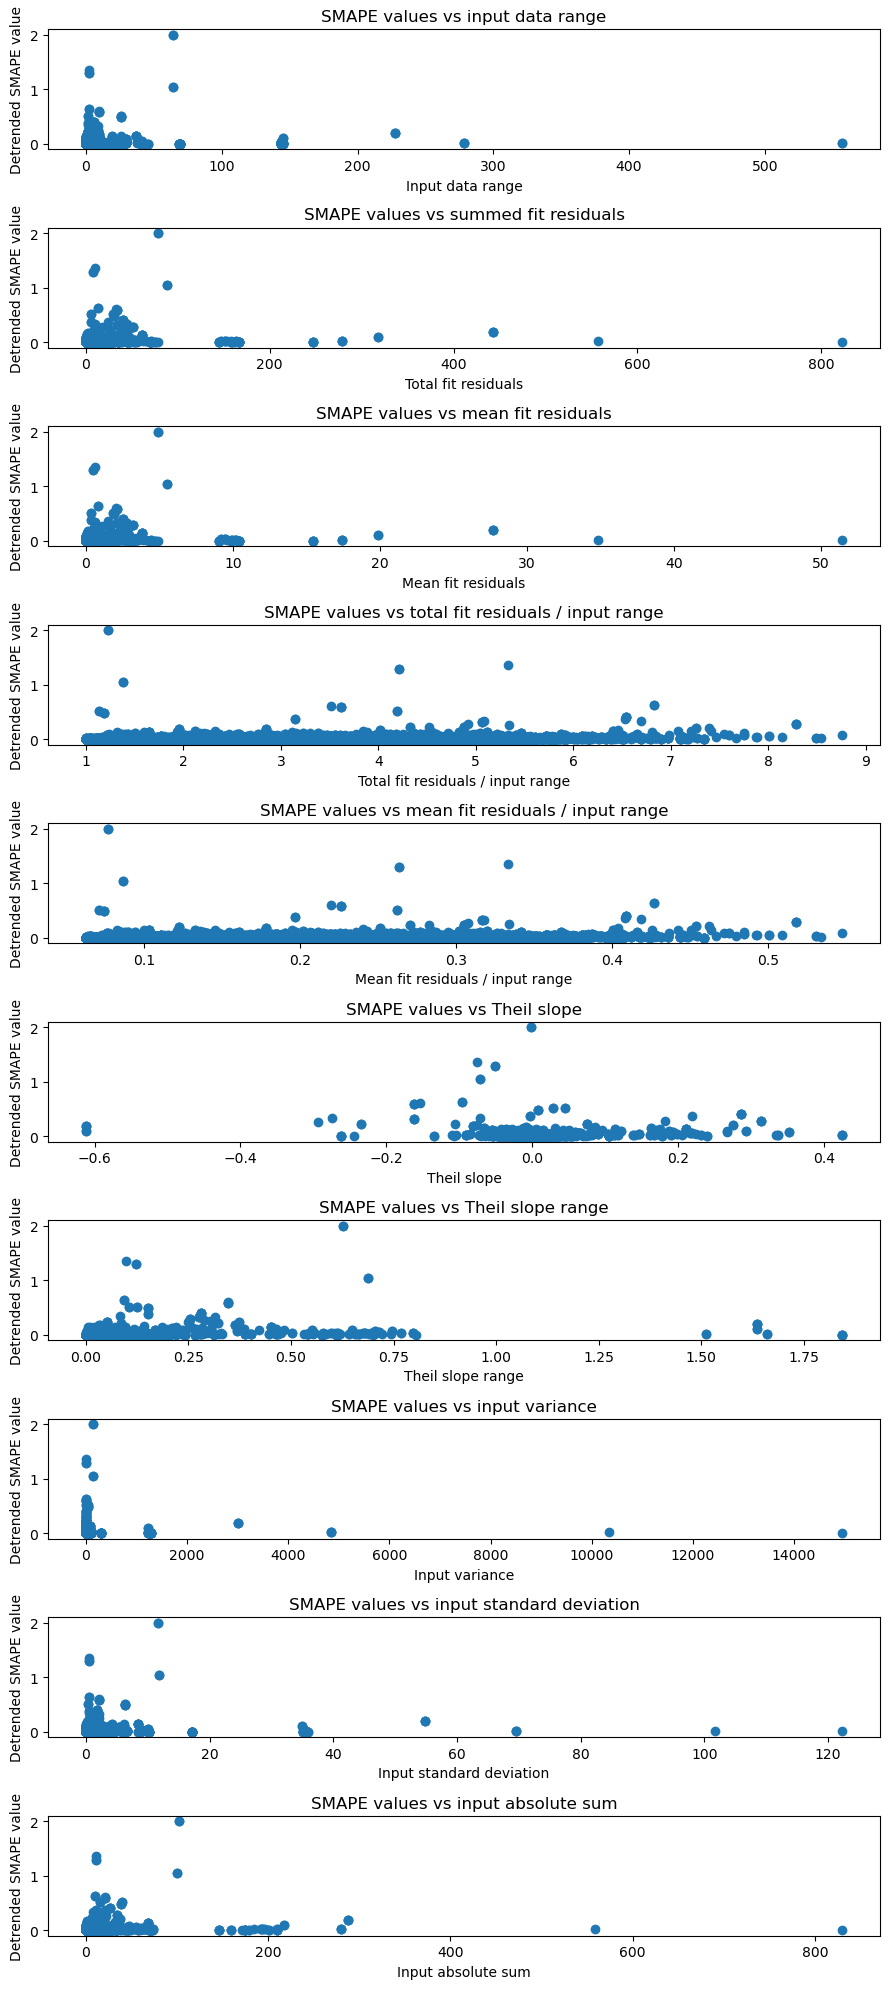

In [65]:
fig, ax = plt.subplots(10, 1, figsize=(9,20))

ax[0].scatter(
    data_ranges,
    SMAPE_values
)
ax[0].set_xlabel('Input data range')
ax[0].set_ylabel('Detrended SMAPE value')
ax[0].title.set_text('SMAPE values vs input data range')

ax[1].scatter(
    total_fit_residuals,
    SMAPE_values
)
ax[1].set_xlabel(f'Total fit residuals')
ax[1].set_ylabel(f'Detrended SMAPE value')
ax[1].title.set_text('SMAPE values vs summed fit residuals')

ax[2].scatter(
    mean_fit_residuals,
    SMAPE_values
)
ax[2].set_xlabel(f'Mean fit residuals')
ax[2].set_ylabel(f'Detrended SMAPE value')
ax[2].title.set_text('SMAPE values vs mean fit residuals')

ax[3].scatter(
    total_residuals_as_fraction_of_range,
    SMAPE_values
)
ax[3].set_xlabel(f'Total fit residuals / input range')
ax[3].set_ylabel(f'Detrended SMAPE value')
ax[3].title.set_text('SMAPE values vs total fit residuals / input range')

ax[4].scatter(
    mean_residuals_as_fraction_of_range,
    SMAPE_values
)
ax[4].set_xlabel(f'Mean fit residuals / input range')
ax[4].set_ylabel(f'Detrended SMAPE value')
ax[4].title.set_text('SMAPE values vs mean fit residuals / input range')

ax[5].scatter(
    theil_slopes,
    SMAPE_values
)
ax[5].set_xlabel(f'Theil slope')
ax[5].set_ylabel(f'Detrended SMAPE value')
ax[5].title.set_text('SMAPE values vs Theil slope')

ax[6].scatter(
    slope_range,
    SMAPE_values
)
ax[6].set_xlabel(f'Theil slope range')
ax[6].set_ylabel(f'Detrended SMAPE value')
ax[6].title.set_text('SMAPE values vs Theil slope range')

ax[7].scatter(
    input_variance,
    SMAPE_values
)
ax[7].set_xlabel(f'Input variance')
ax[7].set_ylabel(f'Detrended SMAPE value')
ax[7].title.set_text('SMAPE values vs input variance')

ax[8].scatter(
    input_deviation,
    SMAPE_values
)
ax[8].set_xlabel(f'Input standard deviation')
ax[8].set_ylabel(f'Detrended SMAPE value')
ax[8].title.set_text('SMAPE values vs input standard deviation')

ax[9].scatter(
    input_absolute_sum,
    SMAPE_values
)
ax[9].set_xlabel(f'Input absolute sum')
ax[9].set_ylabel(f'Detrended SMAPE value')
ax[9].title.set_text('SMAPE values vs input absolute sum')

#plt.suptitle('Predicted vs actual MBD\nwinning regression model and control')
#plt.setp(ax, xlim=(-5,100), ylim=(-0.05,0.6))
plt.tight_layout()

OK, not making any progress. I think we need a different approach. Let's break this down further. I can imagine two (not necessarily mutually exclusive) scenarios which result in high SMAPE:
1. The next MBD value is crazy, so whatever fit the TS estimator came up with doesn't do a good job.
2. The input data is 'crazy' so the TS estimator does a bad job.

Maybe, let's take a closer look at the high smape data points and include the fit and the predicted and actual values. Hopefully, we can get a better idea of how and why the TS estimator is making bad predictions.

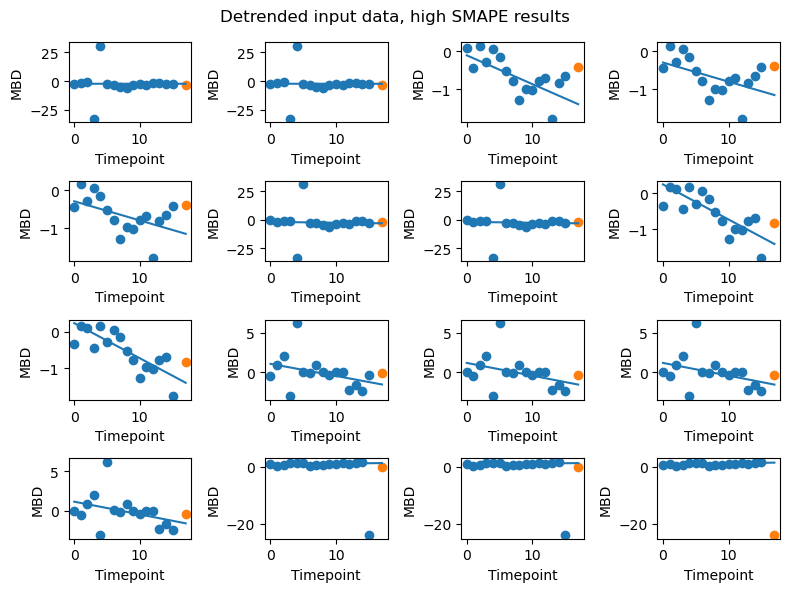

In [66]:
plot_rows = 4
plot_cols = 4
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(8,6))

for i in range(plot_rows):
    for j in range(plot_cols):

        data_point = high_SMAPE.iloc[[plot_num]]
        MBD_values = list(data_point['detrended_MBD_inputs'])[0]
        MBD_actual = list(data_point['MBD_actual'])[0]
        last_input_MBD = list(data_point['MBD_inputs'])[0][-1]
        detrended_MBD_actual = MBD_actual - last_input_MBD
        x_values = list(range(len(MBD_values)))

        # Scatter plot the input data
        ax[i,j].scatter(
            x_values,
            MBD_values
        )
        ax[i,j].set_xlabel(f'Timepoint')
        ax[i,j].set_ylabel(f'MBD')

        # Do the TS fit
        ts = stats.theilslopes(MBD_values, x_values)

        # Recover slope and intercept
        slope = ts[0]
        intercept = ts[1]

        # Plot fit + 1 additional point
        fit_values = []

        for x_value in list(range(len(x_values) + 2)):
            fit_values.append(intercept + slope * x_value)

        ax[i,j].plot(
            list(range(len(x_values) + 2)),
            fit_values
        )

        # Plot actual unknown value

        ax[i,j].scatter(
            len(x_values) + 1,
            detrended_MBD_actual
        )

        plot_num += 1

plt.suptitle('Detrended input data, high SMAPE results')
#plt.setp(ax, xlim=(-10,210), ylim=(-10,210))
plt.tight_layout()

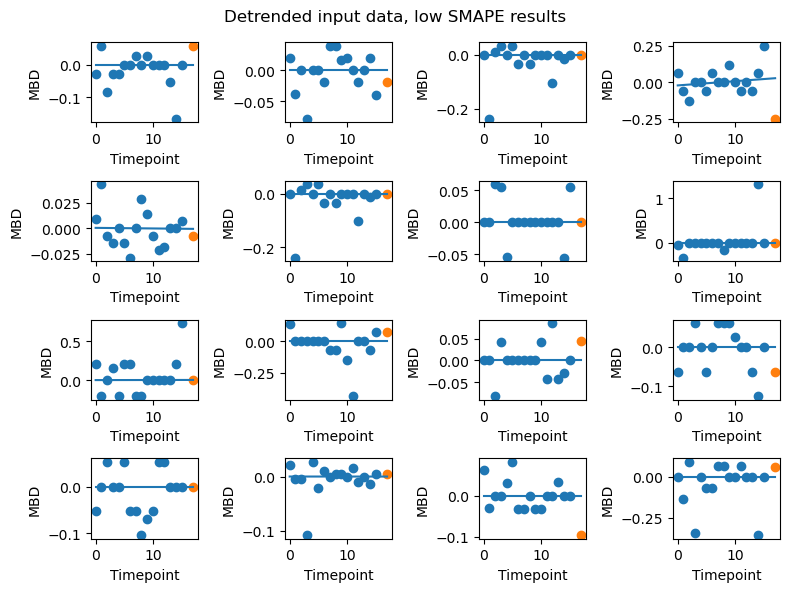

In [67]:
plot_rows = 4
plot_cols = 4
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(8,6))

for i in range(plot_rows):
    for j in range(plot_cols):

        data_point = low_SMAPE.iloc[[plot_num]]
        MBD_values = list(data_point['detrended_MBD_inputs'])[0]
        MBD_actual = list(data_point['MBD_actual'])[0]
        last_input_MBD = list(data_point['MBD_inputs'])[0][-1]
        detrended_MBD_actual = MBD_actual - last_input_MBD
        x_values = list(range(len(MBD_values)))

        # Scatter plot the input data
        ax[i,j].scatter(
            x_values,
            MBD_values
        )
        ax[i,j].set_xlabel(f'Timepoint')
        ax[i,j].set_ylabel(f'MBD')

        # Do the TS fit
        ts = stats.theilslopes(MBD_values, x_values)

        # Recover slope and intercept
        slope = ts[0]
        intercept = ts[1]

        # Plot fit + 1 additional point
        fit_values = []

        for x_value in list(range(len(x_values) + 2)):
            fit_values.append(intercept + slope * x_value)

        ax[i,j].plot(
            list(range(len(x_values) + 2)),
            fit_values
        )

        # Plot actual unknown value

        ax[i,j].scatter(
            len(x_values) + 1,
            detrended_MBD_actual
        )

        plot_num += 1

plt.suptitle('Detrended input data, low SMAPE results')
#plt.setp(ax, xlim=(-10,210), ylim=(-10,210))
plt.tight_layout()

I still feel like the input range should work better than it does. I am starting to worry that we have a data gremlin or two kicking around. There is a lot going on in this notebook. That being said, maybe we are going about this wrong. Maybe we should fit each datapoint with multiple orders and then choose or weight the different predictions. Let's give this notebook a serious once over first to make sure everything is doing what we think it is doing.